# Data Science - Fourth Assignment - Disease Detection
# Mohammad Hossein Basouli - 401222020
---

# Imports

In [173]:
import numpy as np
import pandas as pd

import joblib

from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
import matplotlib.pylab as plt
plt.style.use('ggplot')

pd.set_option('display.max_columns', 35)

# Data Orientation

In [174]:
df = pd.read_csv('train.csv')

In [175]:
df

,ID,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,...,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,label
0,0,1,1,0,1,1,1,1,0,1,1,1,1,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,3
1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,3
2,2,1,1,1,1,0,0,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,3
3,3,1,0,0,0,1,0,0,1,1,1,0,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,7
4,4,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,559,0,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
560,560,1,0,1,1,1,1,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
561,561,1,0,1,0,1,0,0,1,1,1,0,1,0,0,1,1,...,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,10
562,562,1,1,0,0,1,0,1,0,1,0,1,0,1,1,1,1,...,0,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,5


# Exploratory Data Analysis

## Univariate/Bivariate Analysis

### Correlation Between Features:

<Axes: >

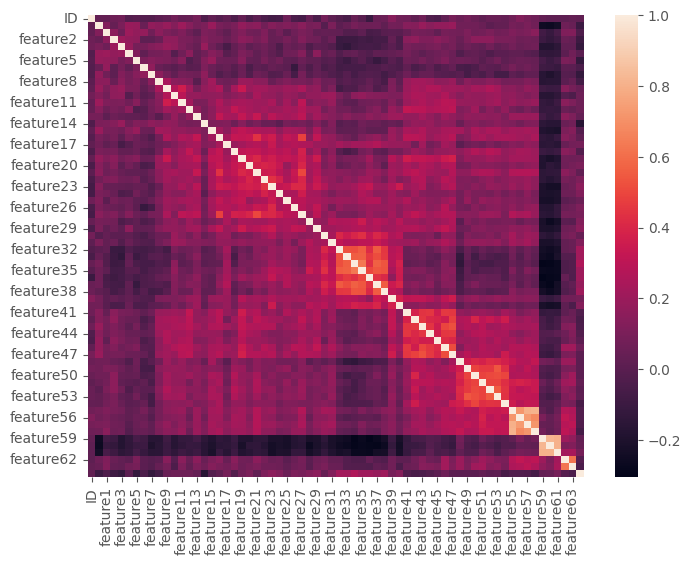

In [176]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr())

### Proportion of the Classes (Diseases):

<Axes: xlabel='label', ylabel='proportion'>

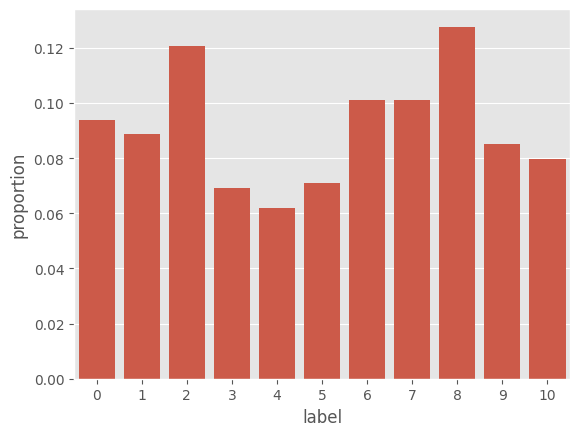

In [177]:
sns.barplot(df['label'].value_counts(normalize=True))

## Data Reduction

### Removing Correlated Features:

In [178]:
X, y = df.drop(columns=['label', 'ID', 'feature57', 'feature58', 'feature60', 'feature61']), df['label']

# Model Training & Evaluation & Interpretation

## Train & Test Split

In [179]:
# Perform stratified train/test split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Scaling

In [180]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training & Evaluation

### Defining a Set of Models to Use:

In [181]:
models = {
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Naive Bayes": BernoulliNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LDA": LinearDiscriminantAnalysis(),
}

### Defining a Grid of Parameters to Tune the Hyperparameters:

In [182]:
param_grids = {
    "Logistic Regression": [
        {
            'penalty': ['l1'],
            'solver': ['liblinear', 'saga'],
            'C': [0.01, 0.1, 1.0, 10.0]
        },
        {
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
            'C': [0.01, 0.1, 1.0, 10.0]
        },
        {
            'penalty': ['elasticnet'],
            'solver': ['saga'],
            'C': [0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.0, 0.5, 1.0]
        },
        {
            'penalty': [None],
            'solver': ['lbfgs', 'sag', 'saga']
        }
    ],

    "Naive Bayes": {
        'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
        'fit_prior': [True, False]
    },
    "SVM": {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    "Random Forest": {
        'n_estimators': [200, 300],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2],
        'max_features': ['log2'],
        'bootstrap': [True]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'estimator__max_depth': [1, 3, 5],
        'estimator__min_samples_split': [2, 5],
        'estimator__min_samples_leaf': [1, 2]
    },
    "XGBoost": {
        'learning_rate': [0.03, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'gamma': [0, 0.5],
        'reg_alpha': [0, 1.0],
        'reg_lambda': [1.0]
    },
    "LDA": [
        {
            'solver': ['svd'],  # svd must be used without shrinkage
        },
        {
            'solver': ['lsqr', 'eigen'],
            'shrinkage': [None, 'auto', 0.0, 0.5, 1.0]  # valid only with these solvers
        }
    ]
}

### Hyperparameter Tuning:

In [183]:
best_models = {}
best_params = {}

for name in models:
    print(f"\n🔍 Running GridSearchCV for {name}...")
    
    grid_search = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_  # 🔐 Save the parameters
    
    print(f"✅ Best Params for {name}: {grid_search.best_params_}")
    print(f"🎯 Best Score: {grid_search.best_score_:.4f}")

# Save each model
for name, model in best_models.items():
    joblib.dump(model, f"./models/{name.replace(' ', '_')}_best_model.pkl")


🔍 Running GridSearchCV for SVM...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best Params for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
🎯 Best Score: 0.3127

🔍 Running GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 39 candidates, totalling 117 fits
✅ Best Params for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
🎯 Best Score: 0.2994

🔍 Running GridSearchCV for Naive Bayes...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Params for Naive Bayes: {'alpha': 0.1, 'fit_prior': True}
🎯 Best Score: 0.3104

🔍 Running GridSearchCV for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best Params for Random Forest: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
🎯 Best Score: 0.3127

🔍 Running GridSearchCV for AdaBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Best Params

### Loading the Best Models Along With Their Best Hyperparameter Combination:

In [184]:
best_models = {}
for name in models:
    model_path = f"./models/{name.replace(' ', '_')}_best_model.pkl"
    best_models[name] = joblib.load(model_path)

### Loading the Final Test Set:

In [185]:
test_df = pd.read_csv('test.csv')
X_test_kaggle = test_df[[f'feature{i}' for i in range(64)]].drop(columns=['feature57', 'feature58', 'feature60', 'feature61'])
X_test_kaggle_scaled = scaler.transform(X_test_kaggle)

### Evaluation on the Train and Test Portions via Voting (Soft Voting):

In [186]:
# Combine loaded models for soft voting
voting_clf = VotingClassifier(
    estimators=[
        (k, v) for k,v in best_models.items()
    ],
    voting='soft',  # Use soft voting
    n_jobs=-1
)

# Fit ensemble on training data
voting_clf.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = voting_clf.predict(X_train_scaled)
y_test_pred = voting_clf.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

name = 'Voting'

# Output results
print(f"\n🧠 VotingClassifier:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))


🧠 VotingClassifier:
Train Accuracy: 0.4191
Test Accuracy:  0.3717
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.11      0.10      0.11        10
           2       0.25      0.14      0.18        14
           3       0.50      0.62      0.56         8
           4       0.43      0.43      0.43         7
           5       0.33      0.12      0.18         8
           6       0.33      0.27      0.30        11
           7       0.64      0.64      0.64        11
           8       0.00      0.00      0.00        14
           9       0.29      0.70      0.41        10
          10       0.27      0.33      0.30         9

    accuracy                           0.37       113
   macro avg       0.34      0.39      0.35       113
weighted avg       0.33      0.37      0.33       113



### Prediction of the Final Test Set via Voting (Soft Voting): 

In [187]:
y_pred = voting_clf.predict(X_test_kaggle_scaled)

# Create a DataFrame with predictions
pred_df = pd.DataFrame({
    'ID': np.arange(y_pred.shape[0]),
    'label': y_pred
})

# Clean model name for filename (no spaces, special chars)
safe_name = name.replace(" ", "_").replace("/", "_")

# Save to CSV
pred_df.to_csv(f"./predictions/{safe_name}_predictions.csv", index=False)

print(f"Saved predictions for {name} to {safe_name}_predictions.csv")

Saved predictions for Voting to Voting_predictions.csv


### Evaluation on the Train and Test Portions with Each Model Separately:

In [188]:
# Train and evaluate
for name, model in best_models.items():
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Output results
    print(f"\n{name}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_test_pred))


SVM
Train Accuracy: 0.7982
Test Accuracy:  0.3717
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.20      0.20      0.20        10
           2       0.22      0.36      0.27        14
           3       0.57      0.50      0.53         8
           4       0.60      0.43      0.50         7
           5       0.00      0.00      0.00         8
           6       0.25      0.09      0.13        11
           7       0.64      0.64      0.64        11
           8       0.18      0.21      0.19        14
           9       0.29      0.50      0.37        10
          10       0.40      0.22      0.29         9

    accuracy                           0.37       113
   macro avg       0.37      0.37      0.36       113
weighted avg       0.36      0.37      0.35       113


Logistic Regression
Train Accuracy: 0.4612
Test Accuracy:  0.3540
Classification Report (Test):
         

/home/mmdproject/env_for_ai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mmdproject/env_for_ai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mmdproject/env_for_ai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


Random Forest
Train Accuracy: 0.9446
Test Accuracy:  0.3628
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        11
           1       0.00      0.00      0.00        10
           2       0.31      0.36      0.33        14
           3       0.50      0.50      0.50         8
           4       0.60      0.43      0.50         7
           5       0.00      0.00      0.00         8
           6       0.14      0.09      0.11        11
           7       0.54      0.64      0.58        11
           8       0.17      0.21      0.19        14
           9       0.40      0.60      0.48        10
          10       0.29      0.22      0.25         9

    accuracy                           0.36       113
   macro avg       0.32      0.36      0.34       113
weighted avg       0.32      0.36      0.33       113


AdaBoost
Train Accuracy: 0.9933
Test Accuracy:  0.3451
Classification Report (Test):
          

### Prediction of the Final Test Set with Each Model Separately: 

In [189]:
for name, model in best_models.items():
    y_pred = model.predict(X_test_kaggle_scaled)

    
    # Create a DataFrame with predictions
    pred_df = pd.DataFrame({
        'ID': np.arange(y_pred.shape[0]),
        'label': y_pred
    })

    # pred_df.reset_index(drop=True, inplace=True)
    # print(pred_df)

    # Clean model name for filename (no spaces, special chars)
    safe_name = name.replace(" ", "_").replace("/", "_")

    # Save to CSV
    pred_df.to_csv(f"./predictions/{safe_name}_predictions.csv", index=False)

    print(f"Saved predictions for {name} to {safe_name}_predictions.csv")

Saved predictions for SVM to SVM_predictions.csv
Saved predictions for Logistic Regression to Logistic_Regression_predictions.csv
Saved predictions for Naive Bayes to Naive_Bayes_predictions.csv
Saved predictions for Random Forest to Random_Forest_predictions.csv
Saved predictions for AdaBoost to AdaBoost_predictions.csv
Saved predictions for XGBoost to XGBoost_predictions.csv
Saved predictions for LDA to LDA_predictions.csv


## Feature Importance

### Feature Importances Using **Mean Decrease Impurity**:

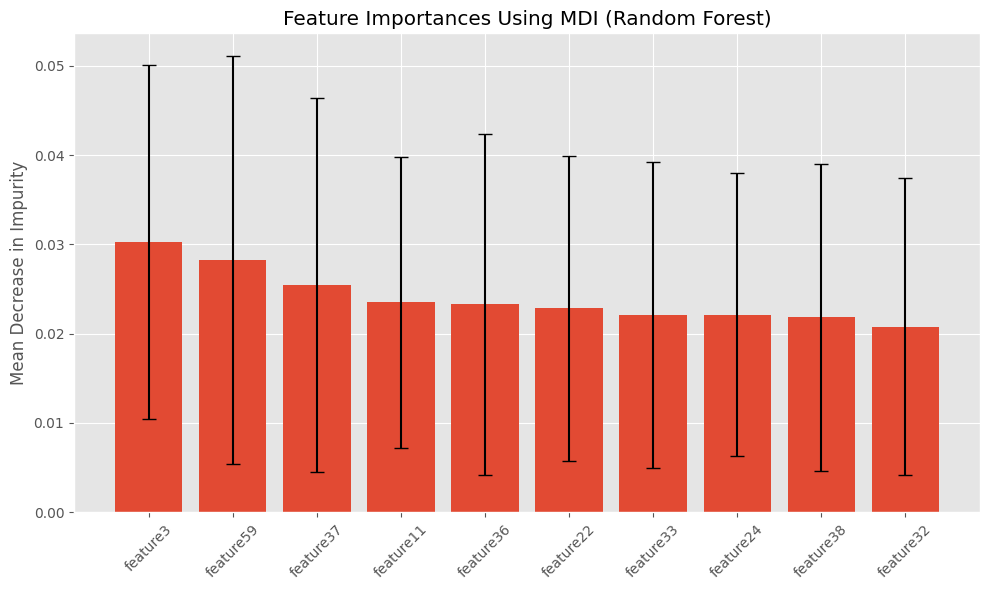

In [190]:
# Compute mean and std
importances = best_models['Random Forest'].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_models['Random Forest'].estimators_], axis=0)

# Create Series and sort top features
forest_importances = pd.Series(importances, index=X_train.columns)
top_n = 10
top_features = forest_importances.sort_values(ascending=False).head(top_n)
top_std = std[top_features.index.map(lambda x: X_train.columns.get_loc(x))]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x=top_features.index, height=top_features.values, yerr=top_std, capsize=5)
plt.title("Feature Importances Using MDI (Random Forest)")
plt.ylabel("Mean Decrease in Impurity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Feature Importances Using **Permutation Test**:

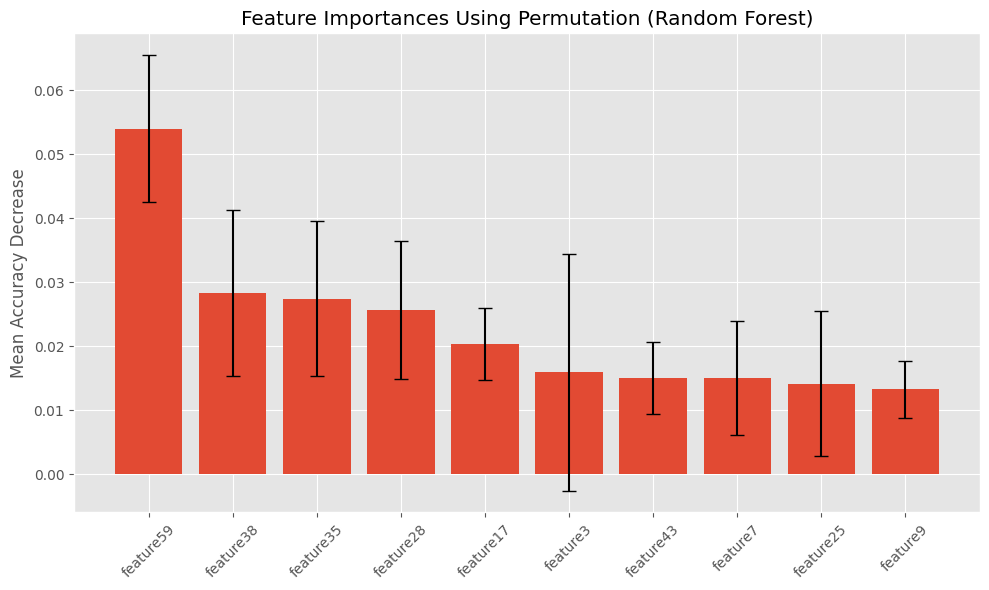

In [191]:
# Run permutation importance
result = permutation_importance(
    best_models['Random Forest'],
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=2
)

# Create a DataFrame for top N features
importances = result.importances_mean
std = result.importances_std
feature_names = X_train.columns

# Sort and select top 10
indices = np.argsort(importances)[::-1]
top_n = 10
top_indices = indices[:top_n]
top_features = feature_names[top_indices]
top_importances = importances[top_indices]
top_std = std[top_indices]

# Plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(x=top_features, height=top_importances, yerr=top_std, capsize=5)
plt.title("Feature Importances Using Permutation (Random Forest)")
plt.ylabel("Mean Accuracy Decrease")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()